In [1]:
from openai import OpenAI
import numpy as np
import json
from os import listdir

## Pipeline

In [ ]:
client = OpenAI(api_key = '')

In [164]:
sound_files = listdir('./Stimulus/Audio/Preprocessed/mp3')
sound_files = [file for file in sound_files if "Full" in file]
file_path = './Stimulus/Audio/Preprocessed/mp3/'

for sound in sound_files:
    complete_path = file_path + sound
    
    print('--------' + sound + '----------')
    audio_file = open(complete_path, "rb")
    transcript = client.audio.transcriptions.create(
      file=audio_file,
      model="whisper-1",
      response_format="verbose_json",
      timestamp_granularities=["word"]
    )
    
    print('transcription is done')
    
    transcription = {}
    transcription['text'] = transcript.text
    transcription['duration'] = transcript.duration
    transcription['words'] = transcript.words
        
    words = transcript.text.split()

    # Create the progressive list
    progressive_list = [' '.join(words[:i+1]) for i in range(len(words))]
    
    surprisals = []
    
    for prompt in progressive_list:
        response = client.completions.create(
            model="davinci-002",
            prompt=prompt,
            max_tokens=1,
            n=1,  # Number of completions to generate
            logprobs=1,  # Top 5 tokens
            echo = True
        )

        surprisals.append(response.choices[0].logprobs.token_logprobs[:-1])
        
    cleaned_surprisal = []
    prev_surprisal = None
    for i in range(len(surprisals)):
        if i == 0:
            surprisals[i][0] = 0
            cleaned_surprisal.append(np.mean(surprisals[i]))
            prev_surprisal = surprisals[i]
        else:
            current_surprisal = surprisals[i]
            diff = len(current_surprisal) - len(prev_surprisal)
            if diff > 1:
                cleaned_surprisal.append(np.mean(current_surprisal[-diff:]))
            else:
                cleaned_surprisal.append(current_surprisal[-1])
    
    print('surprisal computation is done')
                
    if len(cleaned_surprisal) == len(words):
        transcription['surprisal'] = cleaned_surprisal
    else:
        raise ValueError("surprisal counts is different from transcription counts. Surprisal count: " + str(len(cleaned_surprisal)) + '. Transcription count: ' + str(len(words)))
    
    with open('./Stimulus/Audio/Audio_Transcription/' + sound[:-3] + 'json', 'w') as f:
        json.dump(transcription, f)
        
    print(sound[:-3] + 'json' + ' is saved')

--------Duolingo_Full.mp3----------
transcription is done
surprisal computation is done
Duolingo_Full.json is saved
--------Halluciation_Full.mp3----------
transcription is done
surprisal computation is done
Halluciation_Full.json is saved
--------Hater_Full.mp3----------
transcription is done
surprisal computation is done
Hater_Full.json is saved
--------Language_Full.mp3----------
transcription is done
surprisal computation is done
Language_Full.json is saved
--------SarahJones_Full.mp3----------
transcription is done
surprisal computation is done
SarahJones_Full.json is saved


## Visualizing the continuous surprisal for the complete speech

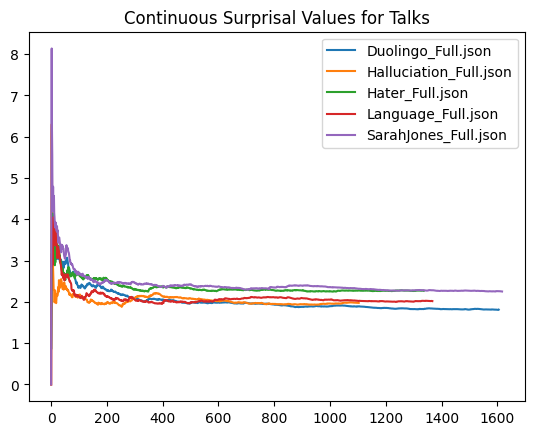

In [25]:
import matplotlib.pyplot as plt

transcription_files = listdir('./Stimulus/Audio/Audio_Transcription')
transcription_files = [file for file in transcription_files if "Full" in file]

for file in transcription_files:
    with open('./Stimulus/Audio/Audio_Transcription/' + file) as f:
        data = json.load(f)
    
    plt.plot(np.abs(data['surprisal']))
plt.title('Continuous Surprisal Values for Talks')
plt.legend(transcription_files)